In [2]:
from google.colab import drive
ROOT = "/content/gdrive"
drive.mount(ROOT, force_remount=True)

Mounted at /content/gdrive


In [0]:
import sys
import os
folder = '/content/gdrive/My Drive/Colab Notebooks/my_project1/deep-learning/utils'
#sys.path.append(folder)
os.chdir(folder)

In [4]:
#from torchvision import transforms
import torch.nn as nn
from helper import HelperModel
from dataset_info import DataSetInfo
from dataloader import DataLoader
#from models.resnet import *
from models.resnet_gradcam import ResNet18_GradCam
from transforms import Transform
from train import Train
from test import Test
from plot import Plot
from albumentations import *
from albumentations.pytorch import ToTensor
from gradcam import *
from albumentation import AlbumentationImageDataset
import matplotlib.pyplot as plt
from lr_finder import LRFinder

  pip install torch-lr-finder -v --global-option="amp"


In [5]:
model_obj = ResNet18_GradCam()
#model_obj = resnet_gradcam.ResNet18_Gradcam()
# create object for Model
device = HelperModel.get_device()

model = model_obj.to(device)

#create object for helper with object
helper_obj = HelperModel(model_obj)

#display summaru of model
helper_obj.display_model_summay(model, (3, 32, 32))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

### Apply Albumentation

In [0]:
patch_size = 32
custom_transforms = [
       Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
       HorizontalFlip(),
       #HueSaturationValue(hue_shift_limit=(-25,0),sat_shift_limit=0,val_shift_limit=0,p=1),
       Cutout(num_holes=1, max_h_size=16,max_w_size = 16,p=1),
       ToTensor()
    ]

train_transforms = Compose(custom_transforms)
test_transform = Compose(
    [
     Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
     ToTensor(),
     ])
data_set_obj = DataSetInfo("cifa", "./data")
train_transforms = AlbumentationImageDataset(data_set_obj, transforms = train_transforms)
test_transforms = AlbumentationImageDataset(data_set_obj, transforms = test_transform)


### Get Train and Test data set

In [7]:
train_set = data_set_obj.get_train_dataset(train_transforms)
test_set = data_set_obj.get_test_dataset(test_transforms)

Files already downloaded and verified
Files already downloaded and verified


### Load the train and test data

In [8]:
data_loader_obj = DataLoader(train_set, test_set, batch_size=64)
train_loader = data_loader_obj.train_loader
test_loader = data_loader_obj.test_loader

CUDA Available? True


### Display some training images to visualize the effect of cutout

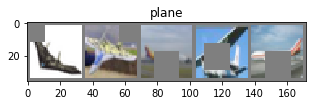

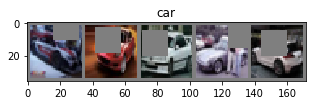

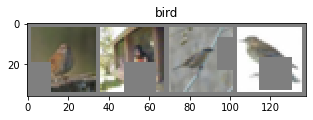

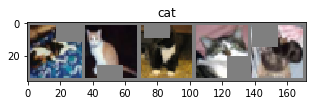

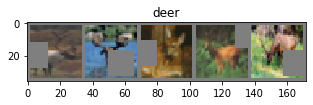

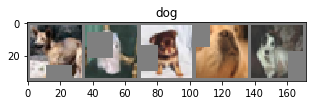

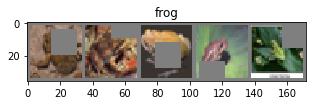

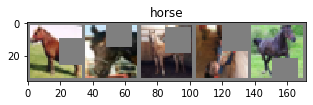

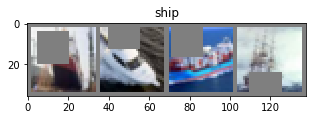

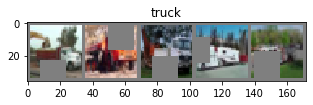

In [8]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
Plot.plot_transormed_images(train_loader, classes)

### Best Training LR fnding


Learning rate search finished. See the graph with {finder_name}.plot()


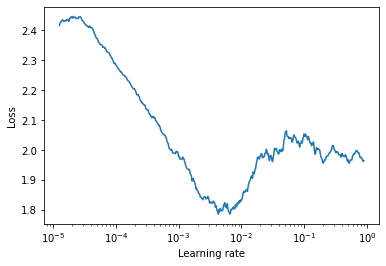

Best LR:  0.004317879727332022
Best loss 1.784891234297257


In [10]:
# Use SGD optimizer
criterion = nn.CrossEntropyLoss()
optimizer = helper_obj.get_l2_regularizer(weight_decay=0.001, lr=1e-5, momentum=0.9) #SGD with l2 regulizer
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=1, num_iter=500, step_mode="exp")
lr_finder.plot()
best_training_lr = lr_finder.get_best_lr()
lr_finder.reset()

### Validation LR finding


Learning rate search finished. See the graph with {finder_name}.plot()


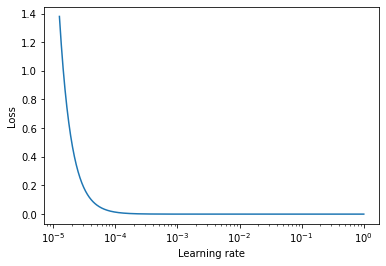

Best LR:  0.9999999999999999
Best loss 1.76431656754499e-11


In [11]:
lr_finder.range_test(train_loader, val_loader=test_loader, end_lr=1, num_iter=500, step_mode="exp")
lr_finder.plot(skip_end=0)
validation_lr = lr_finder.get_best_lr()
lr_finder.reset()

### Run Model

In [12]:
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
optimizer = helper_obj.get_l2_regularizer(lr=best_training_lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', verbose=True)
EPOCHS = 50
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
train_obj = Train()
test_obj = Test()
train_max_acc = []
train_min_loss = []
criterion = nn.CrossEntropyLoss()
for epoch in range(1, EPOCHS+1):
    print("EPOCH:", epoch)
    train_obj.train(model, device, train_loader, optimizer, criterion)
    if epoch < EPOCHS:
        test_obj.test(model, device, test_loader, criterion, misclassfied_required=False, trueclassified_required=False, classes=classes, class_accuracy=90)
    else:
        # store only last epochsreult for misclassfied and trueclassified images
        test_obj.test(model, device, test_loader, criterion, misclassfied_required=True, trueclassified_required=True, classes=classes, class_accuracy=90)
    scheduler.step(metrics=test_obj.test_losses[-1])
    train_max_acc.append(train_obj.train_acc[-1])
    train_min_loss.append(train_obj.train_losses[-1])
miscassified_images = test_obj.misclassified_images
correctcassified_images = test_obj.trueclassified_images
test_losses = test_obj.test_losses
test_acc = test_obj.test_acc
print("Maximum Training Accuracy = ", max(train_max_acc))
print("Maximum Testing Accuracy = ", max(test_acc))




  0%|          | 0/782 [00:00<?, ?it/s]

EPOCH: 1


Train Set: Train Loss=1.0130962133407593 Batch_id=781 Accuracy=48.76: 100%|██████████| 782/782 [01:52<00:00,  6.98it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0158, Accuracy: 6403/10000 (64.03%)

EPOCH: 2


Train Set: Train Loss=1.5135177373886108 Batch_id=781 Accuracy=65.95: 100%|██████████| 782/782 [01:51<00:00,  7.00it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0119, Accuracy: 7413/10000 (74.13%)

EPOCH: 3


Train Set: Train Loss=1.4625885486602783 Batch_id=781 Accuracy=72.38: 100%|██████████| 782/782 [01:50<00:00,  7.05it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0104, Accuracy: 7717/10000 (77.17%)

EPOCH: 4


Train Set: Train Loss=0.26916420459747314 Batch_id=781 Accuracy=75.90: 100%|██████████| 782/782 [01:49<00:00,  7.12it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0091, Accuracy: 8006/10000 (80.06%)

EPOCH: 5


Train Set: Train Loss=0.6199782490730286 Batch_id=781 Accuracy=78.42: 100%|██████████| 782/782 [01:50<00:00,  7.06it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0115, Accuracy: 7568/10000 (75.68%)

EPOCH: 6


Train Set: Train Loss=0.38458845019340515 Batch_id=781 Accuracy=80.45: 100%|██████████| 782/782 [01:50<00:00,  7.07it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0077, Accuracy: 8343/10000 (83.43%)

EPOCH: 7


Train Set: Train Loss=0.5606294870376587 Batch_id=781 Accuracy=81.98: 100%|██████████| 782/782 [01:50<00:00,  7.06it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0074, Accuracy: 8400/10000 (84.00%)

EPOCH: 8


Train Set: Train Loss=0.2095300555229187 Batch_id=781 Accuracy=83.16: 100%|██████████| 782/782 [01:50<00:00,  7.08it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0068, Accuracy: 8550/10000 (85.50%)

EPOCH: 9


Train Set: Train Loss=1.0029689073562622 Batch_id=781 Accuracy=84.10: 100%|██████████| 782/782 [01:50<00:00,  7.07it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0071, Accuracy: 8451/10000 (84.51%)

EPOCH: 10


Train Set: Train Loss=0.272474080324173 Batch_id=781 Accuracy=85.21: 100%|██████████| 782/782 [01:50<00:00,  7.07it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0083, Accuracy: 8309/10000 (83.09%)

EPOCH: 11


Train Set: Train Loss=0.6014240384101868 Batch_id=781 Accuracy=86.03: 100%|██████████| 782/782 [01:51<00:00,  7.00it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0064, Accuracy: 8624/10000 (86.24%)

EPOCH: 12


Train Set: Train Loss=0.3827017545700073 Batch_id=781 Accuracy=86.69: 100%|██████████| 782/782 [01:51<00:00,  7.02it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0064, Accuracy: 8671/10000 (86.71%)

EPOCH: 13


Train Set: Train Loss=0.2757038474082947 Batch_id=781 Accuracy=87.38: 100%|██████████| 782/782 [01:51<00:00,  7.01it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0102, Accuracy: 8107/10000 (81.07%)

EPOCH: 14


Train Set: Train Loss=0.33251848816871643 Batch_id=781 Accuracy=87.99: 100%|██████████| 782/782 [01:51<00:00,  7.02it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0066, Accuracy: 8660/10000 (86.60%)

EPOCH: 15


Train Set: Train Loss=0.04798981547355652 Batch_id=781 Accuracy=88.29: 100%|██████████| 782/782 [01:51<00:00,  7.02it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0073, Accuracy: 8561/10000 (85.61%)

EPOCH: 16


Train Set: Train Loss=0.9987267255783081 Batch_id=781 Accuracy=88.98: 100%|██████████| 782/782 [01:51<00:00,  7.02it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0062, Accuracy: 8718/10000 (87.18%)

EPOCH: 17


Train Set: Train Loss=0.2930052876472473 Batch_id=781 Accuracy=89.08: 100%|██████████| 782/782 [01:51<00:00,  7.01it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0072, Accuracy: 8544/10000 (85.44%)

EPOCH: 18


Train Set: Train Loss=0.5552967190742493 Batch_id=781 Accuracy=89.73: 100%|██████████| 782/782 [01:51<00:00,  7.01it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 8744/10000 (87.44%)

EPOCH: 19


Train Set: Train Loss=0.2516671419143677 Batch_id=781 Accuracy=90.16: 100%|██████████| 782/782 [01:51<00:00,  7.00it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 8921/10000 (89.21%)

EPOCH: 20


Train Set: Train Loss=0.17183244228363037 Batch_id=781 Accuracy=90.53: 100%|██████████| 782/782 [01:51<00:00,  7.01it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 8960/10000 (89.60%)

EPOCH: 21


Train Set: Train Loss=0.15318597853183746 Batch_id=781 Accuracy=90.98: 100%|██████████| 782/782 [01:51<00:00,  7.01it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0066, Accuracy: 8704/10000 (87.04%)

EPOCH: 22


Train Set: Train Loss=0.1490813046693802 Batch_id=781 Accuracy=90.91: 100%|██████████| 782/782 [01:51<00:00,  7.04it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0065, Accuracy: 8640/10000 (86.40%)

EPOCH: 23


Train Set: Train Loss=0.5437064170837402 Batch_id=781 Accuracy=91.19: 100%|██████████| 782/782 [01:51<00:00,  7.01it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 8894/10000 (88.94%)

EPOCH: 24


Train Set: Train Loss=0.4185345768928528 Batch_id=781 Accuracy=91.47: 100%|██████████| 782/782 [01:51<00:00,  7.03it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 8996/10000 (89.96%)

EPOCH: 25


Train Set: Train Loss=0.3150458335876465 Batch_id=781 Accuracy=91.77: 100%|██████████| 782/782 [01:51<00:00,  7.02it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0055, Accuracy: 8859/10000 (88.59%)

EPOCH: 26


Train Set: Train Loss=0.14277808368206024 Batch_id=781 Accuracy=91.85: 100%|██████████| 782/782 [01:51<00:00,  7.03it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0061, Accuracy: 8743/10000 (87.43%)

EPOCH: 27


Train Set: Train Loss=0.5025212168693542 Batch_id=781 Accuracy=92.28: 100%|██████████| 782/782 [01:51<00:00,  7.02it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0062, Accuracy: 8737/10000 (87.37%)

EPOCH: 28


Train Set: Train Loss=0.34106361865997314 Batch_id=781 Accuracy=92.30: 100%|██████████| 782/782 [01:51<00:00,  7.03it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 8937/10000 (89.37%)

EPOCH: 29


Train Set: Train Loss=0.41163018345832825 Batch_id=781 Accuracy=92.50: 100%|██████████| 782/782 [01:51<00:00,  7.01it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 8920/10000 (89.20%)

EPOCH: 30


Train Set: Train Loss=0.16146282851696014 Batch_id=781 Accuracy=93.03: 100%|██████████| 782/782 [01:51<00:00,  7.04it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 8919/10000 (89.19%)

EPOCH: 31


Train Set: Train Loss=0.520588755607605 Batch_id=781 Accuracy=92.81: 100%|██████████| 782/782 [01:51<00:00,  7.02it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 8930/10000 (89.30%)

EPOCH: 32


Train Set: Train Loss=0.3964126706123352 Batch_id=781 Accuracy=93.00: 100%|██████████| 782/782 [01:51<00:00,  7.03it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0055, Accuracy: 8852/10000 (88.52%)

EPOCH: 33


Train Set: Train Loss=0.29136601090431213 Batch_id=781 Accuracy=93.17: 100%|██████████| 782/782 [01:51<00:00,  7.03it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 8988/10000 (89.88%)

EPOCH: 34


Train Set: Train Loss=0.079475998878479 Batch_id=781 Accuracy=93.12: 100%|██████████| 782/782 [01:51<00:00,  7.04it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 8978/10000 (89.78%)

EPOCH: 35


Train Set: Train Loss=0.11463332176208496 Batch_id=781 Accuracy=93.47: 100%|██████████| 782/782 [01:51<00:00,  7.03it/s]



Test set: Average loss: 0.0049, Accuracy: 9019/10000 (90.19%)





  0%|          | 0/782 [00:00<?, ?it/s]

Accuracy of plane : 96 %
Accuracy of   car : 98 %
Accuracy of  bird : 76 %
Accuracy of   cat : 80 %
Accuracy of  deer : 94 %
Accuracy of   dog : 76 %
Accuracy of  frog : 96 %
Accuracy of horse : 91 %
Accuracy of  ship : 96 %
Accuracy of truck : 90 %
Epoch    35: reducing learning rate of group 0 to 4.3179e-04.
EPOCH: 36


Train Set: Train Loss=0.3667464256286621 Batch_id=781 Accuracy=96.34: 100%|██████████| 782/782 [01:51<00:00,  7.03it/s]



Test set: Average loss: 0.0036, Accuracy: 9224/10000 (92.24%)





  0%|          | 0/782 [00:00<?, ?it/s]

Accuracy of plane : 92 %
Accuracy of   car : 98 %
Accuracy of  bird : 89 %
Accuracy of   cat : 95 %
Accuracy of  deer : 96 %
Accuracy of   dog : 75 %
Accuracy of  frog : 96 %
Accuracy of horse : 98 %
Accuracy of  ship : 89 %
Accuracy of truck : 96 %
EPOCH: 37


Train Set: Train Loss=0.03181496262550354 Batch_id=781 Accuracy=97.05: 100%|██████████| 782/782 [01:51<00:00,  7.02it/s]



Test set: Average loss: 0.0035, Accuracy: 9253/10000 (92.53%)





  0%|          | 0/782 [00:00<?, ?it/s]

Accuracy of plane : 90 %
Accuracy of   car : 98 %
Accuracy of  bird : 94 %
Accuracy of   cat : 87 %
Accuracy of  deer : 96 %
Accuracy of   dog : 84 %
Accuracy of  frog : 95 %
Accuracy of horse : 94 %
Accuracy of  ship : 90 %
Accuracy of truck : 93 %
EPOCH: 38


Train Set: Train Loss=0.050857365131378174 Batch_id=781 Accuracy=97.40: 100%|██████████| 782/782 [01:51<00:00,  7.03it/s]



Test set: Average loss: 0.0035, Accuracy: 9275/10000 (92.75%)





  0%|          | 0/782 [00:00<?, ?it/s]

Accuracy of plane : 90 %
Accuracy of   car : 98 %
Accuracy of  bird : 90 %
Accuracy of   cat : 81 %
Accuracy of  deer : 97 %
Accuracy of   dog : 89 %
Accuracy of  frog : 98 %
Accuracy of horse : 98 %
Accuracy of  ship : 92 %
Accuracy of truck : 95 %
EPOCH: 39


Train Set: Train Loss=0.16375496983528137 Batch_id=781 Accuracy=97.61: 100%|██████████| 782/782 [01:51<00:00,  7.03it/s]



Test set: Average loss: 0.0035, Accuracy: 9263/10000 (92.63%)





  0%|          | 0/782 [00:00<?, ?it/s]

Accuracy of plane : 94 %
Accuracy of   car : 98 %
Accuracy of  bird : 93 %
Accuracy of   cat : 79 %
Accuracy of  deer : 100 %
Accuracy of   dog : 83 %
Accuracy of  frog : 96 %
Accuracy of horse : 93 %
Accuracy of  ship : 94 %
Accuracy of truck : 91 %
EPOCH: 40


Train Set: Train Loss=0.010827451944351196 Batch_id=781 Accuracy=97.69: 100%|██████████| 782/782 [01:50<00:00,  7.07it/s]



Test set: Average loss: 0.0035, Accuracy: 9288/10000 (92.88%)





  0%|          | 0/782 [00:00<?, ?it/s]

Accuracy of plane : 92 %
Accuracy of   car : 97 %
Accuracy of  bird : 93 %
Accuracy of   cat : 83 %
Accuracy of  deer : 96 %
Accuracy of   dog : 90 %
Accuracy of  frog : 98 %
Accuracy of horse : 95 %
Accuracy of  ship : 95 %
Accuracy of truck : 89 %
EPOCH: 41


Train Set: Train Loss=0.11607798933982849 Batch_id=781 Accuracy=97.96: 100%|██████████| 782/782 [01:50<00:00,  7.08it/s]



Test set: Average loss: 0.0034, Accuracy: 9294/10000 (92.94%)





  0%|          | 0/782 [00:00<?, ?it/s]

Accuracy of plane : 90 %
Accuracy of   car : 100 %
Accuracy of  bird : 88 %
Accuracy of   cat : 84 %
Accuracy of  deer : 93 %
Accuracy of   dog : 87 %
Accuracy of  frog : 98 %
Accuracy of horse : 87 %
Accuracy of  ship : 95 %
Accuracy of truck : 94 %
EPOCH: 42


Train Set: Train Loss=0.024229109287261963 Batch_id=781 Accuracy=98.06: 100%|██████████| 782/782 [01:51<00:00,  7.04it/s]



Test set: Average loss: 0.0035, Accuracy: 9298/10000 (92.98%)





  0%|          | 0/782 [00:00<?, ?it/s]

Accuracy of plane : 93 %
Accuracy of   car : 95 %
Accuracy of  bird : 79 %
Accuracy of   cat : 86 %
Accuracy of  deer : 96 %
Accuracy of   dog : 97 %
Accuracy of  frog : 94 %
Accuracy of horse : 96 %
Accuracy of  ship : 94 %
Accuracy of truck : 98 %
EPOCH: 43


Train Set: Train Loss=0.07061178982257843 Batch_id=781 Accuracy=98.08: 100%|██████████| 782/782 [01:51<00:00,  7.00it/s]



Test set: Average loss: 0.0034, Accuracy: 9294/10000 (92.94%)





  0%|          | 0/782 [00:00<?, ?it/s]

Accuracy of plane : 90 %
Accuracy of   car : 92 %
Accuracy of  bird : 90 %
Accuracy of   cat : 86 %
Accuracy of  deer : 96 %
Accuracy of   dog : 81 %
Accuracy of  frog : 95 %
Accuracy of horse : 94 %
Accuracy of  ship : 98 %
Accuracy of truck : 93 %
EPOCH: 44


Train Set: Train Loss=0.13076601922512054 Batch_id=781 Accuracy=98.20: 100%|██████████| 782/782 [01:51<00:00,  7.04it/s]



Test set: Average loss: 0.0035, Accuracy: 9301/10000 (93.01%)





  0%|          | 0/782 [00:00<?, ?it/s]

Accuracy of plane : 93 %
Accuracy of   car : 96 %
Accuracy of  bird : 94 %
Accuracy of   cat : 80 %
Accuracy of  deer : 94 %
Accuracy of   dog : 92 %
Accuracy of  frog : 91 %
Accuracy of horse : 95 %
Accuracy of  ship : 93 %
Accuracy of truck : 94 %
EPOCH: 45


Train Set: Train Loss=0.11192306876182556 Batch_id=781 Accuracy=98.30: 100%|██████████| 782/782 [01:51<00:00,  7.04it/s]



Test set: Average loss: 0.0035, Accuracy: 9305/10000 (93.05%)





  0%|          | 0/782 [00:00<?, ?it/s]

Accuracy of plane : 94 %
Accuracy of   car : 98 %
Accuracy of  bird : 93 %
Accuracy of   cat : 85 %
Accuracy of  deer : 91 %
Accuracy of   dog : 87 %
Accuracy of  frog : 90 %
Accuracy of horse : 94 %
Accuracy of  ship : 93 %
Accuracy of truck : 97 %
EPOCH: 46


Train Set: Train Loss=0.020570218563079834 Batch_id=781 Accuracy=98.30: 100%|██████████| 782/782 [01:51<00:00,  7.04it/s]



Test set: Average loss: 0.0034, Accuracy: 9320/10000 (93.20%)





  0%|          | 0/782 [00:00<?, ?it/s]

Accuracy of plane : 95 %
Accuracy of   car : 94 %
Accuracy of  bird : 90 %
Accuracy of   cat : 89 %
Accuracy of  deer : 95 %
Accuracy of   dog : 85 %
Accuracy of  frog : 98 %
Accuracy of horse : 100 %
Accuracy of  ship : 98 %
Accuracy of truck : 100 %
EPOCH: 47


Train Set: Train Loss=0.09873506426811218 Batch_id=781 Accuracy=98.32: 100%|██████████| 782/782 [01:51<00:00,  7.03it/s]



Test set: Average loss: 0.0035, Accuracy: 9311/10000 (93.11%)





  0%|          | 0/782 [00:00<?, ?it/s]

Accuracy of plane : 91 %
Accuracy of   car : 98 %
Accuracy of  bird : 91 %
Accuracy of   cat : 84 %
Accuracy of  deer : 92 %
Accuracy of   dog : 88 %
Accuracy of  frog : 93 %
Accuracy of horse : 94 %
Accuracy of  ship : 95 %
Accuracy of truck : 95 %
EPOCH: 48


Train Set: Train Loss=0.06113356351852417 Batch_id=781 Accuracy=98.44: 100%|██████████| 782/782 [01:51<00:00,  7.04it/s]



Test set: Average loss: 0.0034, Accuracy: 9305/10000 (93.05%)





  0%|          | 0/782 [00:00<?, ?it/s]

Accuracy of plane : 95 %
Accuracy of   car : 95 %
Accuracy of  bird : 98 %
Accuracy of   cat : 96 %
Accuracy of  deer : 90 %
Accuracy of   dog : 90 %
Accuracy of  frog : 95 %
Accuracy of horse : 95 %
Accuracy of  ship : 93 %
Accuracy of truck : 92 %
EPOCH: 49


Train Set: Train Loss=0.1698070466518402 Batch_id=781 Accuracy=98.44: 100%|██████████| 782/782 [01:51<00:00,  7.01it/s]



Test set: Average loss: 0.0035, Accuracy: 9306/10000 (93.06%)





  0%|          | 0/782 [00:00<?, ?it/s]

Accuracy of plane : 92 %
Accuracy of   car : 95 %
Accuracy of  bird : 90 %
Accuracy of   cat : 90 %
Accuracy of  deer : 96 %
Accuracy of   dog : 89 %
Accuracy of  frog : 98 %
Accuracy of horse : 90 %
Accuracy of  ship : 93 %
Accuracy of truck : 98 %
EPOCH: 50


Train Set: Train Loss=0.016915559768676758 Batch_id=781 Accuracy=98.55: 100%|██████████| 782/782 [01:51<00:00,  7.03it/s]



Test set: Average loss: 0.0035, Accuracy: 9315/10000 (93.15%)



Accuracy of plane : 92 %
Accuracy of   car : 98 %
Accuracy of  bird : 91 %
Accuracy of   cat : 81 %
Accuracy of  deer : 96 %
Accuracy of   dog : 93 %
Accuracy of  frog : 94 %
Accuracy of horse : 96 %
Accuracy of  ship : 96 %
Accuracy of truck : 98 %
Maximum Training Accuracy =  98.55
Maximum Testing Accuracy =  93.2


In [0]:
from google.colab import files
# print("Our model: \n\n", model, '\n')
# print("The state dict keys: \n\n", model.state_dict().keys())
torch.save(model.state_dict(), 'checkpoint.pth')
files.download('checkpoint.pth')

In [14]:
len(miscassified_images)

685

### Visualizing gradcam results for miss classified images in layer4

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2796: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


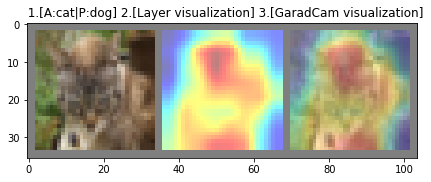

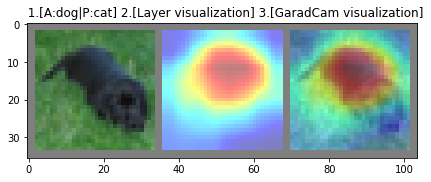

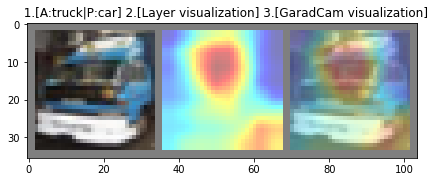

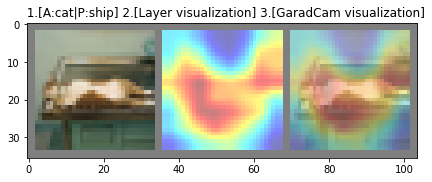

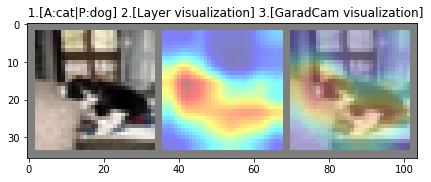

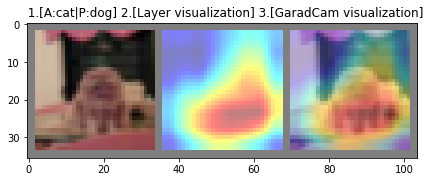

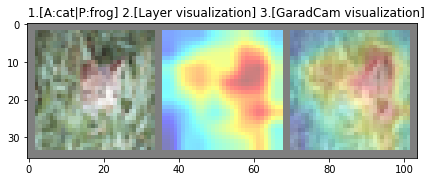

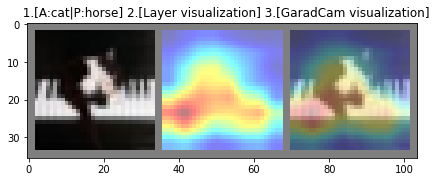

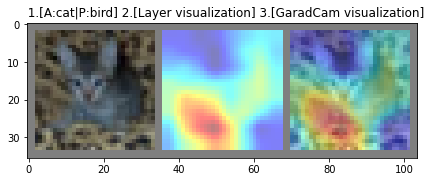

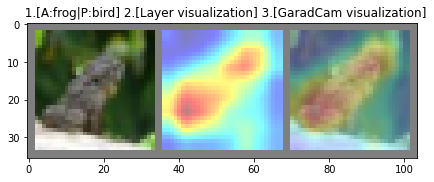

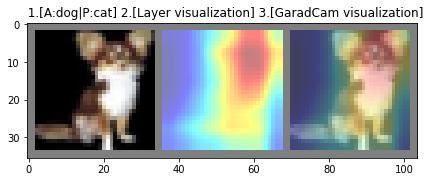

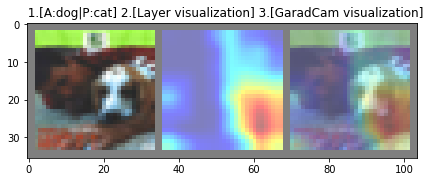

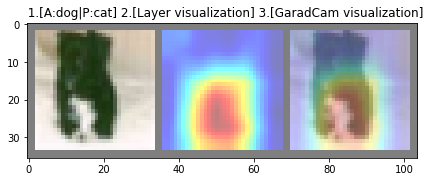

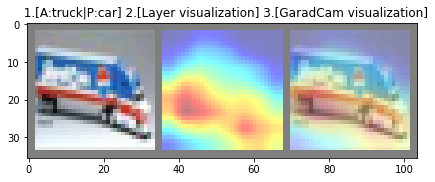

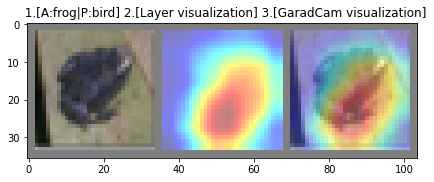

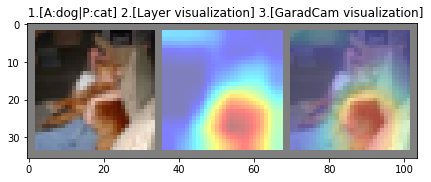

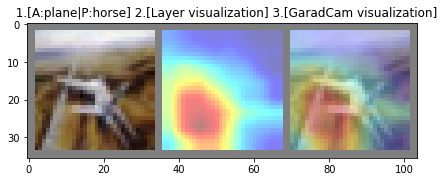

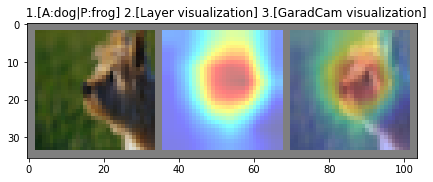

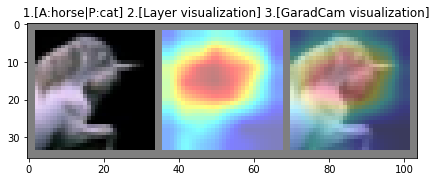

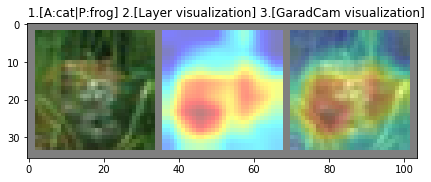

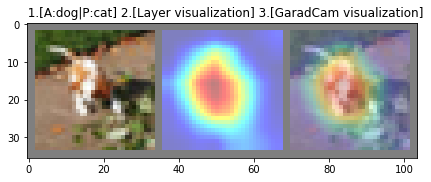

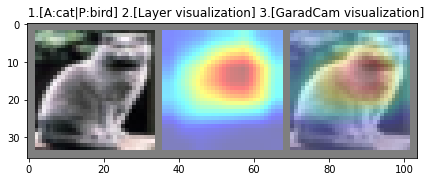

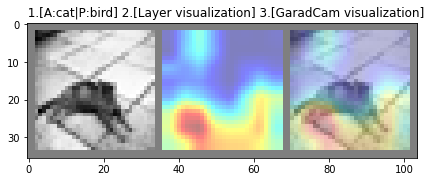

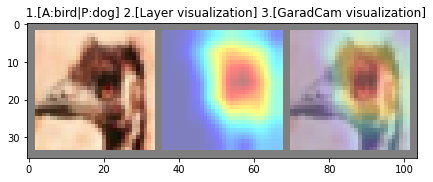

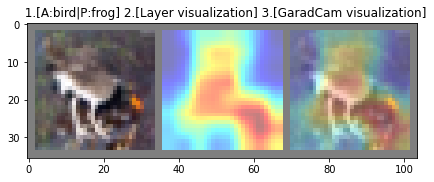

In [19]:
from torchvision.utils import make_grid
num_img = 25
for index in range(num_img):
  images = []
  grad_cam = GradCAM(model, model.layer4)
  mask, _ = grad_cam(torch.stack([miscassified_images[index][0]]))
  heatmap, result = visualize_cam(mask, miscassified_images[index][0])
  images.extend([miscassified_images[index][0].cpu(), heatmap, result])
  label = "  1.[A:{0}|P:{1}] 2.[Layer visualization] 3.[GaradCam visualization]".format(classes[miscassified_images[index][2].item()], classes[miscassified_images[index][1].item()])
  Plot.image_show(make_grid(images, nrow=5), title=label, download_image="gradcam_missclassified_{0}.png".format(index+1))

###Visualizing Gradcam results for mis classified images in all 4 layers

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2796: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


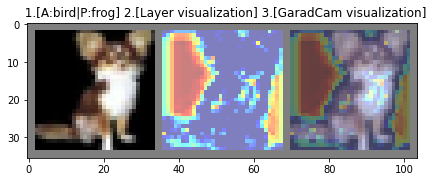

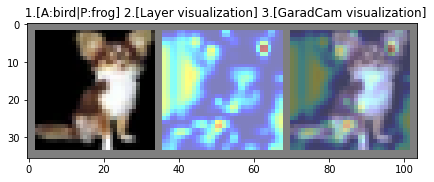

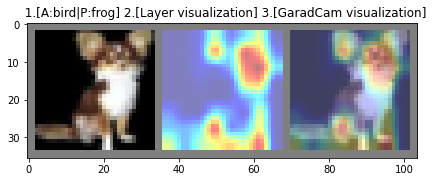

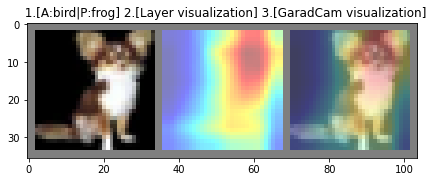

In [21]:
image = miscassified_images[10] #take one random image from mis classidfied images
layer_details = [model.layer1, model.layer2, model.layer3, model.layer4]
for i, model_layer in enumerate(layer_details):
    images = []
    grad_cam = GradCAM(model, model_layer)
    mask, _ = grad_cam(torch.stack([image[0]]))
    heatmap, result = visualize_cam(mask, image[0])
    images.extend([image[0].cpu(), heatmap, result])
    label = "  1.[A:{0}|P:{1}] 2.[Layer visualization] 3.[GaradCam visualization]".format(classes[miscassified_images[index][2].item()], classes[miscassified_images[index][1].item()])
    #label = "  1.[{0}] 2.[layer {1} visualization] 3.[GaradCam visualization]".format(classes[image[2].item()], i+1)
    Plot.image_show(make_grid(images, nrow=5), title=label, download_image="gradcam_layer_{0}.png".format(i+1))



### Visualizing gradcam results for miss classified images in layer4

### Plot graphs

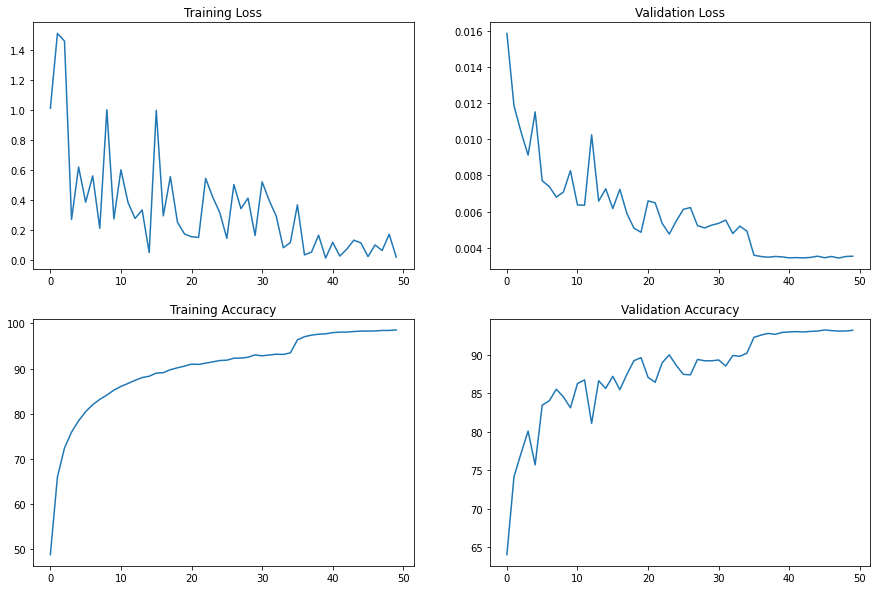

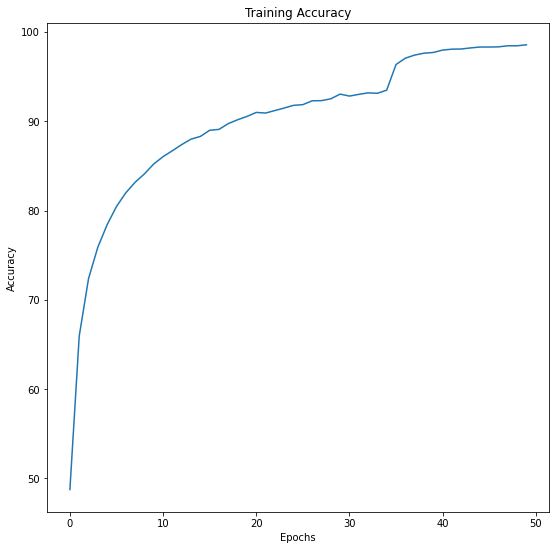

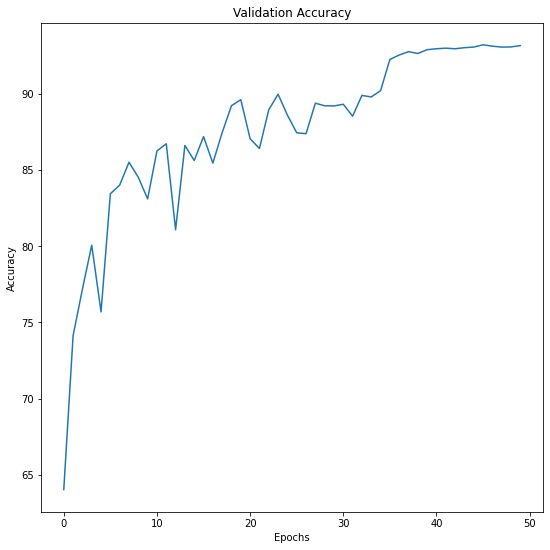

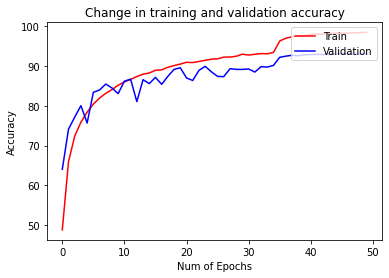

In [38]:
plt_obj = Plot(train_max_acc, train_min_loss, test_acc, test_losses)
# Plot all graph
plt_obj.display_all_plot()
plt_obj.plot_train_graph()
plt_obj.plot_validation_graph()
plt_obj.plot_graph(plot_case="Accuracy")

### Plot misclassified images

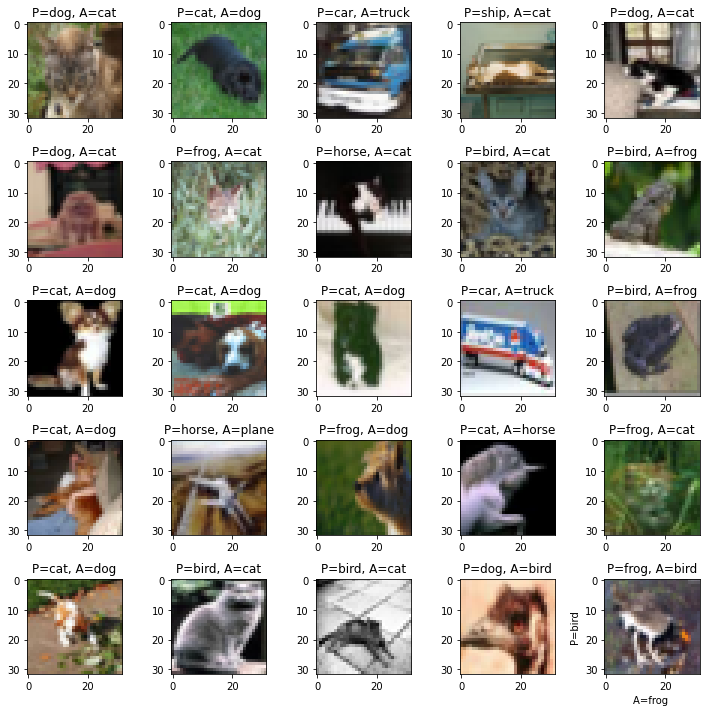

In [23]:
Plot.plot_classified_images(classes, miscassified_images, image_name="gradcam_misclssified.png")